In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import re
import peakutils
import datetime
import warnings
import sys
import logging

sys.path.append('C:\\Users\\IFIc\\Projects\\topatu\\scripts')
from galvo_python.gaussian2dFit import *

In [2]:
plt.rcParams['errorbar.capsize'] = 8
plt.rcParams['font.size'] = 18
plt.rc('font', size= 18)
plt.rc('legend', fontsize= 15)
plt.rc('xtick', labelsize= 14)
plt.rc('ytick', labelsize= 14)
plt.rc('axes', labelsize=14)
plt.rc('axes', titlesize=14)

In [3]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [4]:
path = 'C:/Users/IFIc/Projects/topatu/data/20201124/*.tif'
files = glob.glob(path)
filesAcn = []
filesFBIBa = []
for f in files:
    if 'FBI_Ba' in f:
        filesFBIBa.append(f)
    elif 'ACN' in f:
        filesAcn.append(f)
        
filesFBIBa, filesAcn

(['C:/Users/IFIc/Projects/topatu/data/20201124\\20201124_FBI_Ba_P_197p3mW_900ms_ZT405_532pcr_DMLP425x2_FB43000001.tif',
  'C:/Users/IFIc/Projects/topatu/data/20201124\\20201124_FBI_Ba_P_197p3mW_900ms_ZT405_532pcr_DMLP425x2_FB43000002.tif',
  'C:/Users/IFIc/Projects/topatu/data/20201124\\20201124_FBI_Ba_P_197p3mW_900ms_ZT405_532pcr_DMLP425x2_FB43000003.tif',
  'C:/Users/IFIc/Projects/topatu/data/20201124\\20201124_FBI_Ba_P_197p3mW_900ms_ZT405_532pcr_DMLP425x2_FB43000004.tif',
  'C:/Users/IFIc/Projects/topatu/data/20201124\\20201124_FBI_Ba_P_197p3mW_900ms_ZT405_532pcr_DMLP425x2_FB43000005.tif',
  'C:/Users/IFIc/Projects/topatu/data/20201124\\20201124_FBI_Ba_P_197p3mW_900ms_ZT405_532pcr_DMLP425x2_FB43000006.tif',
  'C:/Users/IFIc/Projects/topatu/data/20201124\\20201124_FBI_Ba_P_197p3mW_900ms_ZT405_532pcr_DMLP425x2_FB43000007.tif',
  'C:/Users/IFIc/Projects/topatu/data/20201124\\20201124_FBI_Ba_P_197p3mW_900ms_ZT405_532pcr_DMLP425x2_FB43000008.tif',
  'C:/Users/IFIc/Projects/topatu/data/20

In [5]:
filename

NameError: name 'filename' is not defined

In [6]:
def extract_p_texp(f):
    texp = re.search('_\d+ms_', f).group(0).replace('ms', '').replace('_', '')

    try:
        pi = re.search('_\d+p\d+mW_', f).group(0).replace('mW', '').replace('_', '').replace('p', '.')
    except AttributeError:
        pi = re.search('_\d+mW_', f).group(0).replace('mW', '').replace('_', '')
    return texp, pi

In [7]:
def extract_pstr(f):
    try:
        pi = re.search('_\d+p\d+mW_', f).group(0)
    except AttributeError:
        pi = re.search('_\d+mW_', f).group(0)
    return pi

In [8]:
def get_pi_texps(files: list)->(list,list):
    """Extract unique (not repeated) incident P and exposure times from filenames
    input:
        files: list with the names of files to look into
    output:
        pi_list: list with unique incident powers (in mW)
        texps: list with unique exposure times"""
    texp0, pi0 = extract_p_texp(files[0])

    texps = [float(texp0)]
    pi_list = [float(pi0)]

    for i,f in enumerate(files):

        texp, pi = extract_p_texp(f)

        if float(pi) != pi_list[-1]:
            pi_list.append(float(pi))
            texps.append(float(texp))
    return pi_list, texps

In [9]:
def get_pi_str(files:list)-> list:
    """Get incident powers as list of strings (ex '_197p3mW_')"""
    pi0 = extract_pstr(filesFBIBa[0])

    pi_str = [pi0]

    for i,f in enumerate(filesFBIBa):

        pi = extract_pstr(f)

        if pi != pi_str[-1]:
            pi_str.append(pi)
    return pi_str

In [10]:
def avg_imgs_by_pi(files: list, pi_str: list)->list:
    """Average images in files (list) classified by identical incident power from pi_str"""
    
    im0 = plt.imread(files[0]).astype(int)
    im_pwr = []
    texps = []
    pi_list = []

    for pi in pi_str:
        n_im = 0
        im_p = np.zeros_like(im0)
        for f in files:
            if pi in f:
                im_p += plt.imread(f).astype(int)
                n_im += 1
        im_pwr.append(im_p/n_im)
    return im_pwr

In [22]:
texp0, pi0 = extract_p_texp(filesFBIBa[0])

texps = [float(texp0)]
pi_list = [float(pi0)]

for i,f in enumerate(filesFBIBa):
    
    texp, pi = extract_p_texp(f)
    
    if float(pi) != pi_list[-1]:
        pi_list.append(float(pi))
        texps.append(float(texp))

In [12]:
pi0 = extract_pstr(filesFBIBa[0])

pi_str = [pi0]

for i,f in enumerate(filesFBIBa):
    
    pi = extract_pstr(f)
    
    if pi != pi_str[-1]:
        pi_str.append(pi)

In [13]:
pi_str

['_197p3mW_', '_300mW_', '_46p5mW_', '_8p1mW_', '_99p8mW_']

In [14]:
im0 = plt.imread(filesFBIBa[0]).astype(int)
imFBI = []

for pi in pi_str:
    n_im = 0
    im_p = np.zeros_like(im0)
    for f in filesFBIBa:
        if pi in f:
            im_p += plt.imread(f).astype(int)
            n_im += 1
    print(n_im)
    imFBI.append(im_p/n_im)

27
22
20
16
22


In [15]:
len(imFBI)

5

In [23]:
pi_list, texps

([197.3, 300.0, 46.5, 8.1, 99.8], [900.0, 900.0, 3600.0, 1000.0, 1900.0])

In [17]:
def mask_image(im: np.array, mask: np.array) -> np.array:
    masked = im.copy()
    masked[~mask] = 0
    return masked

In [24]:
def circular_roi(im: np.array, radius: int = 120)-> np.array:
    mx = guess_centroid(im)
    mask = create_circular_mask(im.shape[0], im.shape[1], center=(mx[1], mx[0]), radius=radius)
    return mask_image(im, mask)

In [25]:
texps

[900.0, 900.0, 3600.0, 1000.0, 1900.0]

In [26]:
texps[3] = 1e4

In [27]:
iem = []
for im, texp in zip(imFBI, texps):
    croi = circular_roi(im, radius = 120)
    iem.append(croi.sum()/texp*1000)

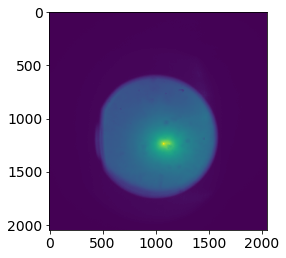

In [28]:
plt.imshow(imFBI[2])

In [29]:
plt.imshow(masked)

NameError: name 'masked' is not defined

In [30]:
pi_str

['_197p3mW_', '_300mW_', '_46p5mW_', '_8p1mW_', '_99p8mW_']

In [236]:
def plot_powerSeries_ims(ims: list, pi_list: list, croi: bool = True):
    fig, ax = plt.subplots(len(ims), figsize=(10, 10*len(ims)))
    for i,(im, name) in enumerate(zip(ims, pi_list)):
        if croi:
            ims = ax[i].imshow(circular_roi(im))
        else:
            ims = ax[i].imshow(im, )

        ax[i].set(title=str(name)+'mW')
        fig.colorbar(ims, ax=ax[i])

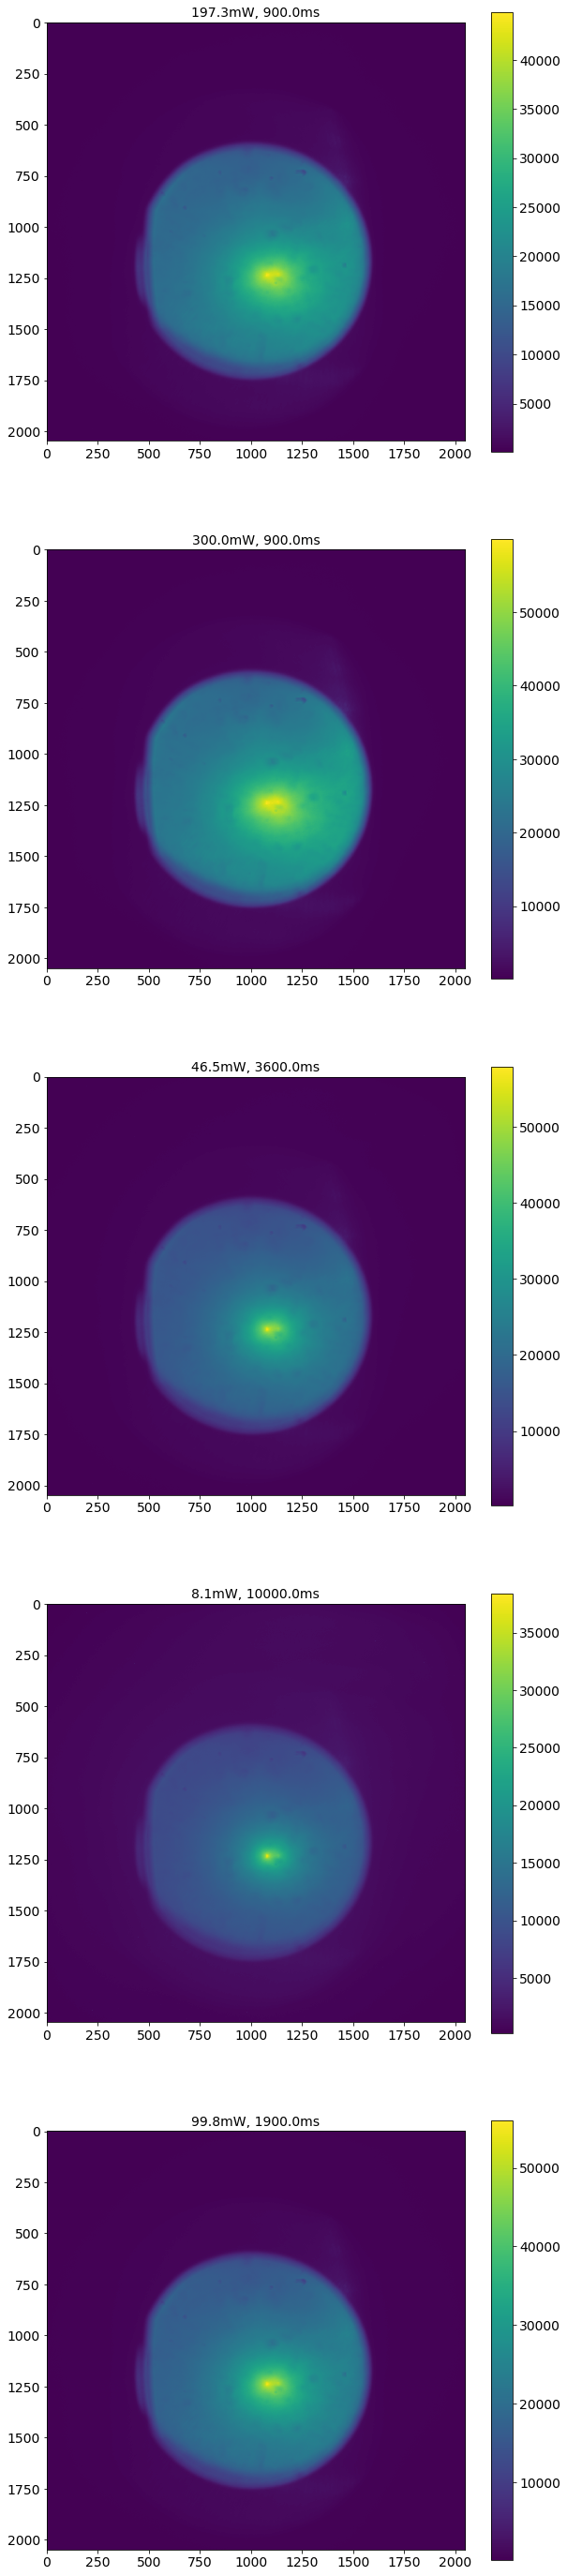

In [31]:
fig, ax = plt.subplots(len(imFBI), figsize=(10, 50))
for i,(im, name) in enumerate(zip(imFBI, pi_list)):
    ims = ax[i].imshow(im, )
    ax[i].set(title=str(name)+'mW, '+str(texps[i])+'ms')
    fig.colorbar(ims, ax=ax[i])

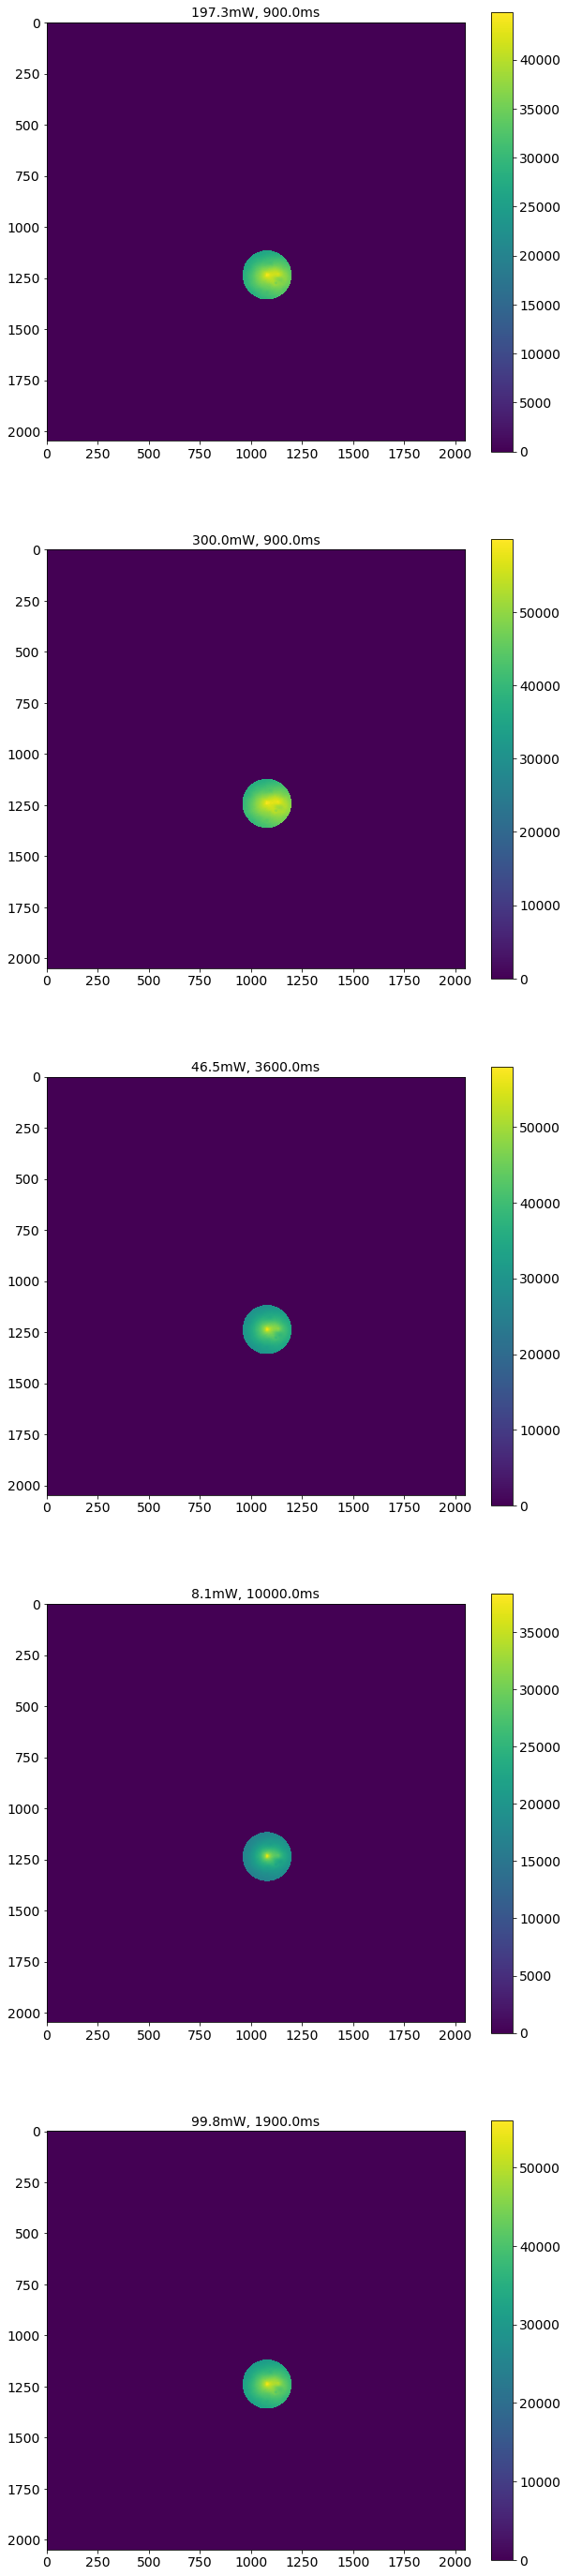

In [32]:
fig, ax = plt.subplots(len(imFBI), figsize=(10, 50))
for i,(im, name) in enumerate(zip(imFBI, pi_list)):
    ims = ax[i].imshow(circular_roi(im) )
    ax[i].set(title=str(name)+'mW, '+str(texps[i])+'ms')
    fig.colorbar(ims, ax=ax[i])

In [43]:
imFBI[0]

array([[161.88888889, 148.7037037 , 147.77777778, ..., 150.55555556,
        172.44444444, 161.37037037],
       [154.25925926, 150.07407407, 153.62962963, ..., 160.85185185,
        167.7037037 , 157.40740741],
       [159.44444444, 157.18518519, 146.96296296, ..., 160.25925926,
        160.66666667, 161.62962963],
       ...,
       [145.66666667, 160.2962963 , 155.74074074, ..., 162.14814815,
        155.62962963, 157.62962963],
       [157.62962963, 155.88888889, 158.11111111, ..., 156.48148148,
        160.48148148, 158.66666667],
       [152.88888889, 169.22222222, 165.96296296, ..., 145.18518519,
        152.40740741, 157.        ]])

In [33]:
diem = [np.sqrt(ie) for ie in iem]
diem

[40778.7746573072,
 48349.60609399465,
 21362.972354507325,
 9791.171312080081,
 30176.427131551496]

In [34]:
np.array(diem)/np.array(iem)

array([2.45225613e-05, 2.06826918e-05, 4.68099656e-05, 1.02132826e-04,
       3.31384493e-05])

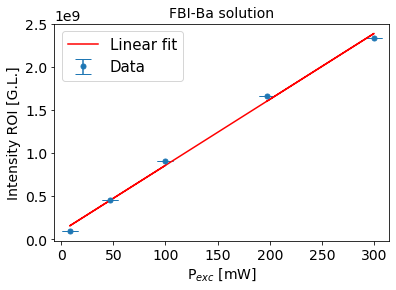

In [35]:
plt.errorbar(x=pi_list, y=iem, yerr=diem, fmt='.', ms=10, label='Data')
coef = np.polyfit(pi_list, iem, 1)
poly1d = np.poly1d(coef)
plt.plot(pi_list, poly1d(pi_list), '-r', label='Linear fit')
plt.gca().set(ylabel='Intensity ROI [G.L.]', xlabel='P$_{exc}$ [mW]', title='FBI-Ba solution')
plt.legend()

## Same for solvent 

In [36]:
piAcn, teAcn = get_pi_texps(filesAcn)
piAcn, teAcn

([197.3, 300.0, 46.5, 8.1, 99.8],
 [10000.0, 10000.0, 10000.0, 10000.0, 10000.0])

In [37]:
pi_strAcn = get_pi_str(filesAcn)
pi_strAcn

['_197p3mW_', '_300mW_', '_46p5mW_', '_8p1mW_', '_99p8mW_']

In [38]:
imAcn = avg_imgs_by_pi(filesAcn, pi_strAcn)

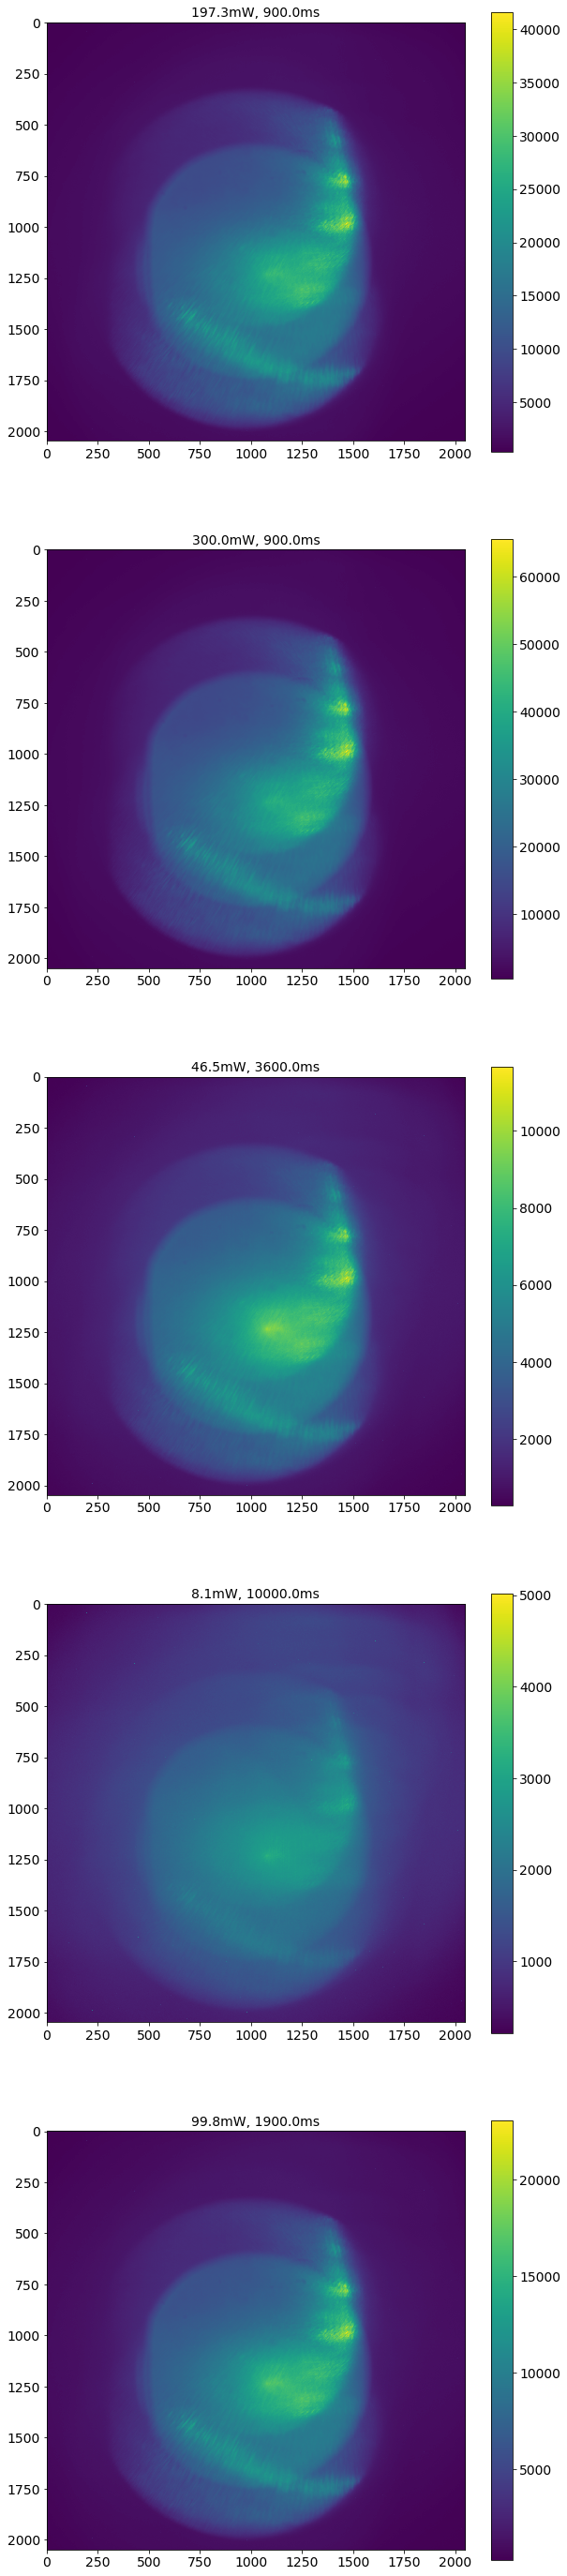

In [39]:
fig, ax = plt.subplots(len(imAcn), figsize=(10, 50))
for i,(im, name) in enumerate(zip(imAcn, pi_list)):
    ims = ax[i].imshow(im, )
    ax[i].set(title=str(name)+'mW, '+str(texps[i])+'ms')
    fig.colorbar(ims, ax=ax[i])

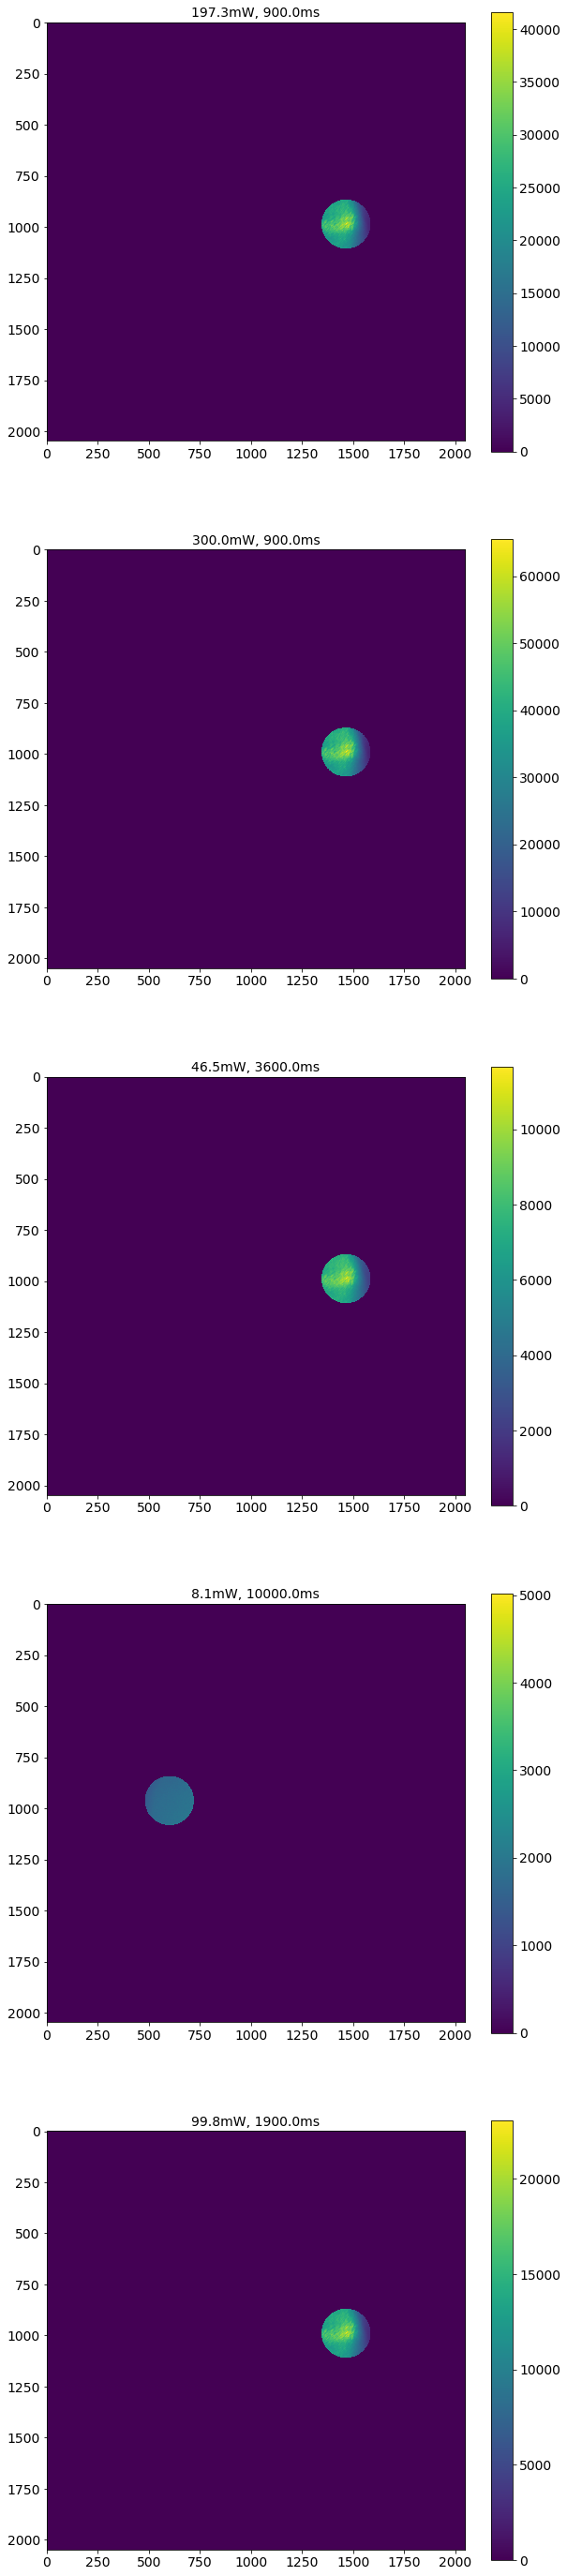

In [40]:
fig, ax = plt.subplots(len(imAcn), figsize=(10, 50))
for i,(im, name) in enumerate(zip(imAcn, pi_list)):
    ims = ax[i].imshow(circular_roi(im))
    ax[i].set(title=str(name)+'mW, '+str(texps[i])+'ms')
    fig.colorbar(ims, ax=ax[i])

In [41]:
iemAcn = []
for im, texp in zip(imAcn, teAcn):
    croi = circular_roi(im, radius = 120)
    iemAcn.append(croi.sum()/texp*1000)

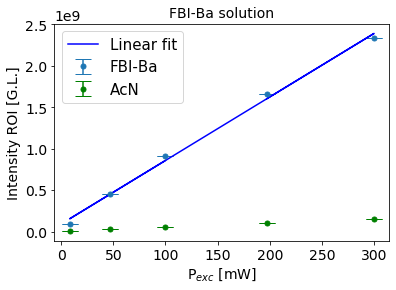

In [42]:
plt.errorbar(x=pi_list, y=iem, yerr=diem, fmt='.', ms=10, label='FBI-Ba')
plt.errorbar(x=pi_list, y=iemAcn, yerr=diem, fmt='.g', ms=10, label='AcN')

coef = np.polyfit(pi_list, iem, 1, )
poly1d = np.poly1d(coef)
plt.plot(pi_list, poly1d(pi_list), '-b', label='Linear fit')
plt.gca().set(ylabel='Intensity ROI [G.L.]', xlabel='P$_{exc}$ [mW]', title='FBI-Ba solution')
plt.legend()

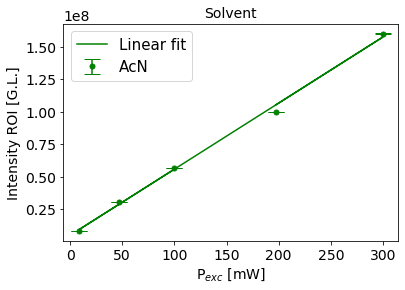

In [225]:
plt.errorbar(x=pi_list, y=iemAcn, yerr=diem, fmt='.g', ms=10, label='AcN')

coef = np.polyfit(pi_list, iemAcn, 1)
poly1d = np.poly1d(coef)
plt.plot(pi_list, poly1d(pi_list), '-g', label='Linear fit')
plt.gca().set(ylabel='Intensity ROI [G.L.]', xlabel='P$_{exc}$ [mW]', title='Solvent')
plt.legend()

In [239]:
coef

array([ 7657971.33158874, 94550666.62145688])

In [235]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(pi_list, iem)
r_value, p_value

(0.9980861626796645, 0.0001004770027807274)

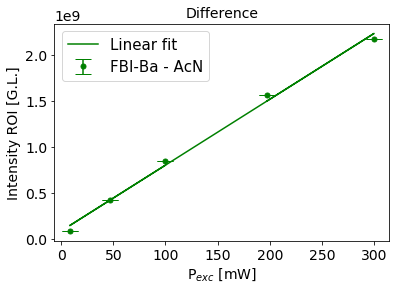

In [230]:
iemDiff = np.array(iem) - np.array(iemAcn)
plt.errorbar(x=pi_list, y=iemDiff, yerr=diem, fmt='.g', ms=10, label='FBI-Ba - AcN')

coef = np.polyfit(pi_list, iemDiff, 1)
poly1d = np.poly1d(coef)
plt.plot(pi_list, poly1d(pi_list), '-g', label='Linear fit')
plt.gca().set(ylabel='Intensity ROI [G.L.]', xlabel='P$_{exc}$ [mW]', title='Difference')
plt.legend()